# Autoencoders

These were directly copied from the corresponding notebook.

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1103)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)
     

## Data

In [ ]:
name = "fashion_mnist"
ds = load_dataset(name)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
x = "image"
y = "label"

In [ ]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(i) for i in b[x]]

In [ ]:
dst = ds.with_transform(transformi)

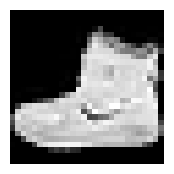

In [ ]:
img = dst["train"][0][x]
show_image(img, figsize=(2,2));

In [ ]:
collate_func = collate_dict(dst["train"])

In [ ]:
def collate_(b):
    return to_device(collate_func(b))

In [ ]:
def data_loaders(ds, bs, **kwargs):
    return {k: DataLoader(v, bs, **kwargs) for k, v in ds.items()}

In [ ]:
dls = data_loaders(dst, 64, collate_fn=collate_)

In [ ]:
dl_train = dls["train"]
dl_valid = dls["test"]

In [ ]:
xb, yb = next(iter(dl_train))

In [ ]:
labels = ds["train"].features[y].names
print(labels)

['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
label_getter = itemgetter(*yb[:16])
titles = label_getter(labels)

In [ ]:
show_images?

Signature:
show_images(
    ims: list,
    nrows: int = None,
    ncols: int = None,
    titles: list = None,
    *,
    figsize: tuple = None,
    imsize: int = 3,
    suptitle: str = None,
    sharex: "bool | Literal['none', 'all', 'row', 'col']" = False,
    sharey: "bool | Literal['none', 'all', 'row', 'col']" = False,
    squeeze: 'bool' = True,
    width_ratios: 'Sequence[float] | None' = None,
    height_ratios: 'Sequence[float] | None' = None,
    subplot_kw: 'dict[str, Any] | None' = None,
    gridspec_kw: 'dict[str, Any] | None' = None,
)
Docstring: Display `ims` in a grid `nrows`x`ncols` with `titles`.
File:      ~/fastai_course/miniai/datasets.py
Type:      function

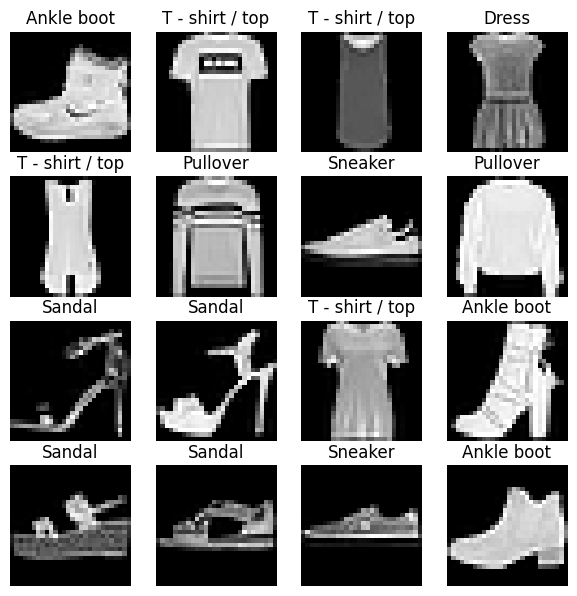

In [ ]:
show_images(xb[:16], 4, 4, titles, imsize=1.8);

## Warmup - classify

In [ ]:
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
bs = 64
lr = 0.1

In [ ]:
cnn = nn.Sequential(        # 28x28
    conv(1, 8),             # 14x14
    conv(8, 16),            #  7x7
    conv(16, 32),           #  4x4
    conv(32, 64),           #  2x2
    conv(64, 10, act=False),#  1x1
    nn.Flatten()
).to(def_device)

In [ ]:
opt = torch.optim.SGD(cnn.parameters(), lr=lr)

In [ ]:
loss, acc = fit(5, cnn, opt, F.cross_entropy, dl_train, dl_valid)

Epoch 0: loss=0.5758, accuracy=0.78
Epoch 1: loss=0.4386, accuracy=0.84
Epoch 2: loss=0.4053, accuracy=0.85
Epoch 3: loss=0.3823, accuracy=0.86
Epoch 4: loss=0.3668, accuracy=0.86


In [ ]:
ds["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

It has to convert from PIL to torch.

In [ ]:
# dls = data_loaders(dst, 64, collate_fn=collate_, num_workers=4)
# dl_train = dls["train"]
# next(iter(dl_train))

## Autoencoder

In [ ]:
a = torch.empty((1, 1, 2, 2))
a.shape

torch.Size([1, 1, 2, 2])

In [ ]:
nn.UpsamplingNearest2d(scale_factor=2)(a).shape

torch.Size([1, 1, 4, 4])

In [ ]:
def deconv(ni, nf, ks=3, act=True):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        conv(ni, nf, ks=ks, stride=1, act=act),
    )

In [ ]:
dec = deconv(1, 2)
dec(a).shape

torch.Size([1, 2, 4, 4])

In [ ]:
def eval(model, loss_func, dl_valid, epoch):
    model.eval()
    with torch.no_grad():
        loss_acc, count = 0., 0
        for xb, yb in dl_valid:
            predb = model(xb)
            loss = loss_func(predb, xb)
            b = xb.shape[0]
            loss_acc += loss.item() * b
            count += b
    print(f"Epoch {epoch}: loss={loss_acc/count:.4f}")

In [ ]:
def fit(epochs, model, loss_func, opt, dl_train, dl_valid):
    for e in range(epochs):
        model.train()
        for xb, yb in dl_train:
            predb = model(xb)
            loss = loss_func(predb, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, dl_valid, e)

In [ ]:
xb = xb.to("cpu")
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
nn.ZeroPad2d?

Init signature: nn.ZeroPad2d(padding: Union[int, Tuple[int, int, int, int]]) -> None
Docstring:     
Pads the input tensor boundaries with zero.

For `N`-dimensional padding, use :func:`torch.nn.functional.pad()`.

Args:
    padding (int, tuple): the size of the padding. If is `int`, uses the same
        padding in all boundaries. If a 4-`tuple`, uses (:math:`\text{padding\_left}`,
        :math:`\text{padding\_right}`, :math:`\text{padding\_top}`, :math:`\text{padding\_bottom}`)

Shape:
    - Input: :math:`(N, C, H_{in}, W_{in})` or :math:`(C, H_{in}, W_{in})`.
    - Output: :math:`(N, C, H_{out}, W_{out})` or :math:`(C, H_{out}, W_{out})`, where

      :math:`H_{out} = H_{in} + \text{padding\_top} + \text{padding\_bottom}`

      :math:`W_{out} = W_{in} + \text{padding\_left} + \text{padding\_right}`

Examples::

    >>> # xdoctest: +IGNORE_WANT("non-deterministic")
    >>> m = nn.ZeroPad2d(2)
    >>> input = torch.randn(1, 1, 3, 3)
    >>> input
    tensor([[[[-0.1678, -0.4418,  1.

In [ ]:
autoencoder = nn.Sequential( #28
    nn.ZeroPad2d(2),         #32
    conv(1, 4),              #16
    conv(4, 8),              #8
    conv(8, 16),             #4
    deconv(16, 8),           #8
    deconv(8, 4),            #16
    deconv(4, 1, act=False), #32
    nn.ZeroPad2d(-2),        #28
    nn.Sigmoid()
)

In [ ]:
autoencoder(xb).shape

torch.Size([64, 1, 28, 28])

In [ ]:
autoencoder = autoencoder.to(def_device)

In [ ]:
eval(autoencoder, F.mse_loss, dl_valid, 0)

Epoch 0: loss=0.1664


In [ ]:
opt = torch.optim.SGD(autoencoder.parameters(), 0.1)

In [ ]:
fit(5, autoencoder, F.mse_loss, opt, dl_train, dl_valid)

Epoch 0: loss=0.1242
Epoch 1: loss=0.1230
Epoch 2: loss=0.0349
Epoch 3: loss=0.0322
Epoch 4: loss=0.0296


In [ ]:
opt = torch.optim.SGD(autoencoder.parameters(), 0.01)
fit(3, autoencoder, F.mse_loss, opt, dl_train, dl_valid)

Epoch 0: loss=0.0279
Epoch 1: loss=0.0278
Epoch 2: loss=0.0276


In [ ]:
xb, _ = next(iter(dl_valid))

In [ ]:
xb = xb[:16]
predb = autoencoder(xb)

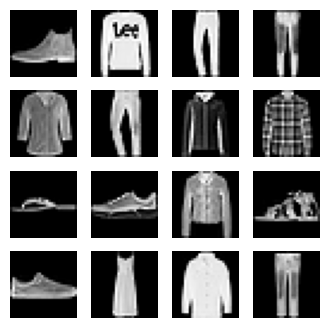

In [ ]:
show_images(xb.cpu(), imsize=1)

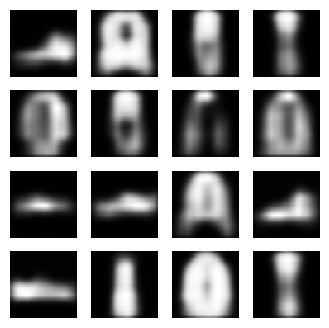

In [ ]:
show_images(predb.cpu(), imsize=1)